# Putting it all together

The goal of this chapter is to provide a fully annotated and functional
script for training a vocals separation model using `nussl` and `Scaper`, 
putting together everything that we've seen in this tutorial thus far. So that
this part runs in reasonable time, we'll set up our model training code so that
it overfits to a small amount of data, and then show the output of the model
on that data. We'll also give instructions on how to scale your experiment code up
so that it's a full MUSDB separation experiment.

We'll have to introduce a few concepts in `nussl` that hasn't been covered yet that
will make our lives easier. Alright, let's get started!

In [1]:
%%capture
!pip install scaper
!pip install nussl
!pip install git+https://github.com/source-separation/tutorial

## Getting the data

The first concept we'll want to be familiar with is that of data transforms. `nussl` provides
a transforms API for audio, much like the one found in `torchvision` does for image data.
Remember all that data code we built up in the previous section? Let's get it back, this
time by just importing it from the `common` module that comes with this tutorial:

In [2]:
%%capture
from common import data, viz
import nussl
# Prepare MUSDB
data.prepare_musdb('~/.nussl/tutorial/')

The next bit of code initializes a Scaper object with all the bells and whistles
that were introduced in the last section, then wraps it in a nussl OnTheFly
dataset. First, we should set our STFTParams to what we'll be using throughout
this notebook:

In [57]:
stft_params = nussl.STFTParams(window_length=512, hop_length=128, window_type='sqrt_hann')
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

AttributeError: module 'common.data' has no attribute 'on_the_fly'

Let's take a look at a single item from the dataset:

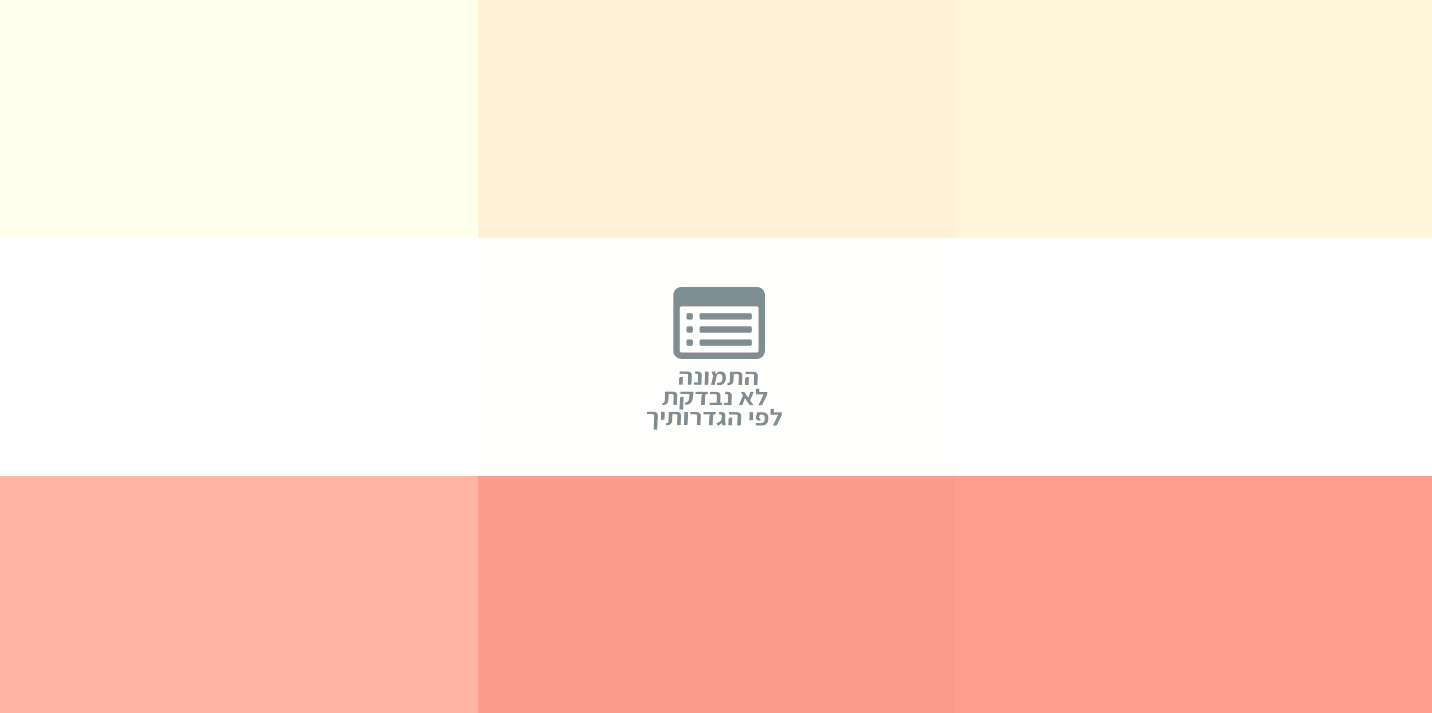


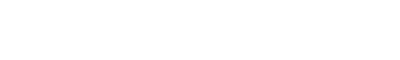
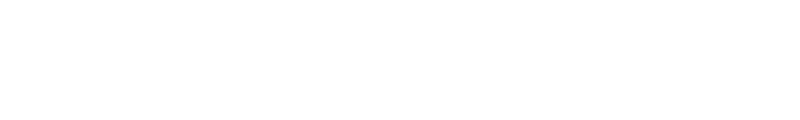
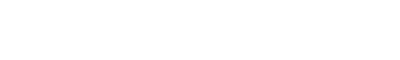

In [4]:
item = train_data[0]
viz.show_sources(item['sources'])

Recall that the mixture above is generated above using Scaper and may be coherent or incoherent!
The ratio is controlled by `data.mixer(..., coherent_prob=0.5)`. Go ahead and use the cell below
to listen to a few more examples, as well as play around with the various arguments to `data.mixer`.

Now that we've got some training data, we'll also need to make validation and test datasets:

In [5]:
fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=500)

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=None, fg_path=fg_path, num_mixtures=100)

Now that we've got all of our data, how do we actually feed it into our model? Each
item from this dataset is structured as a dictionary with the following keys:An 

- `mix`: An AudioSignal object with the mixture of all the sources
- `sources`: A dictionary where keys are source labels, and values are corresponding
   AudioSignal objects.
- `metadata`: Metadata for the item - contains the corresponding JAMS file for the 
   generated mixture.
   
For now, we are mostly concerned with the first two parts. Now, these are AudioSignal
object, so how do we get it into `nussl`? We'll use *transforms*!

### Data transforms

If you've looked at deep learning code for various vision tasks, you might have come
across that looks like this:

```python
>>> transforms.Compose([
>>>     transforms.CenterCrop(10),
>>>     transforms.ToTensor(),
>>> ])
```

Each transform does something to an input image. `Compose` puts the transforms
together so they happen one after the other. In `nussl`, we've built up a very
similar API that takes in dictionaries of AudioSignal objects like above
that are produced by nussl datasets, and applies different transformations 
to them. Specifically, we'll use these transforms from `nussl`:

- `SumSources`: combines the selected sources into a single source. We'll use it to
  combine drums, bass, and other sources into a single accompaniment source, which will
  be helpful when evaluating our model's performance.
- `MagnitudeSpectrumApproximation`: computes the spectrograms of the targets and
  the spectrogram of the mixture. The first is used for our loss and the second is used
  as input to the model.
- `IndexSources`: for the output of the model, we only care about the estimate of the vocals,
  so we'll use this transform to discard the other target spectrograms.
- `ToSeparationModel`: converts all of the values in the dictionary to Tensors so they can
  be fed to our model.
- `Compose`: we'll use this transform to combine all of the above so they happen sequentially.
  
Let's look at each of these transforms and what they do to our data dictionary:

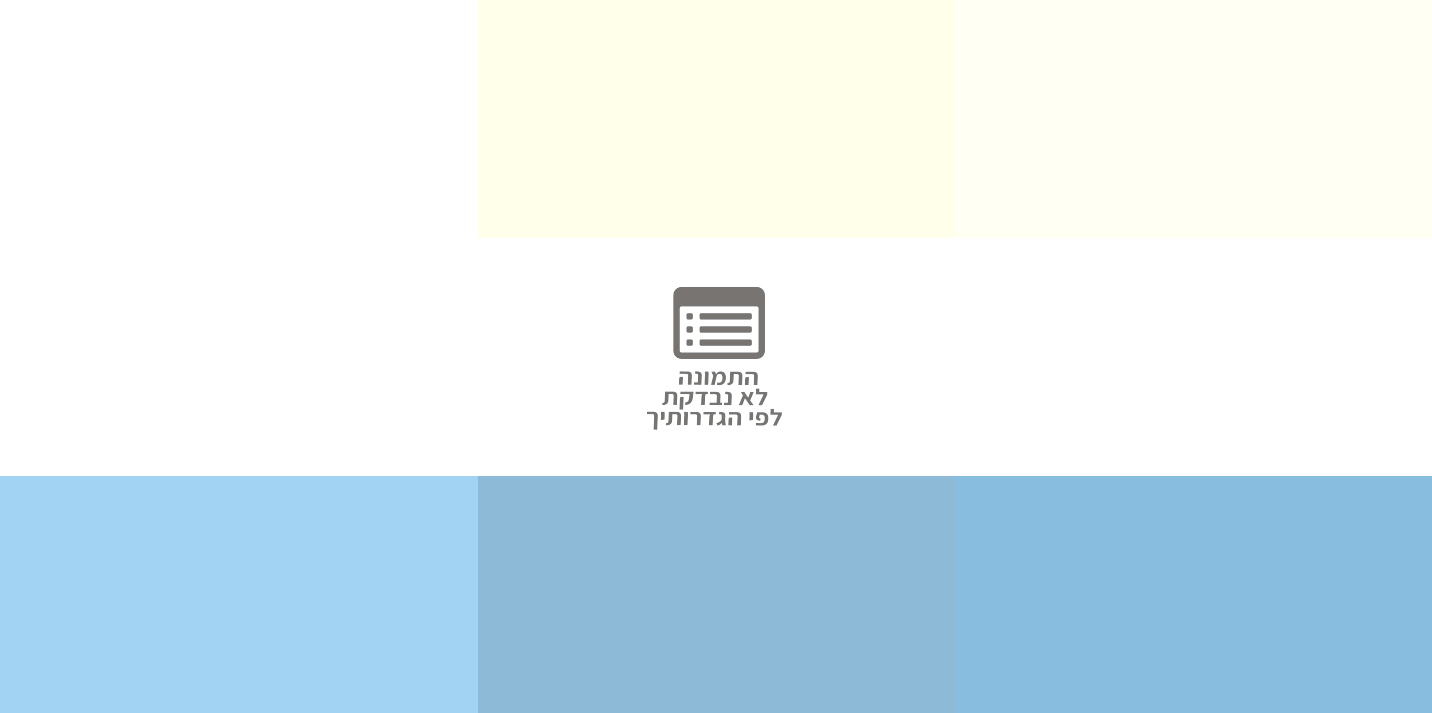


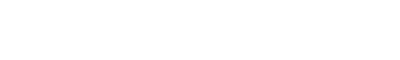
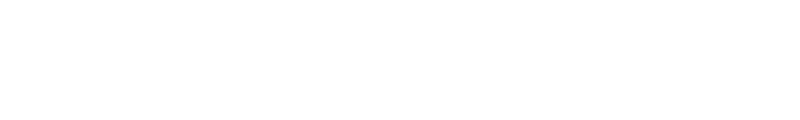
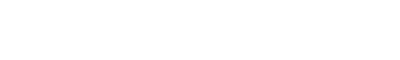

In [6]:
from nussl.datasets import transforms as nussl_tfm

item = train_data[0]
sum_sources = nussl_tfm.SumSources([['bass', 'drums', 'other']])
item = sum_sources(item)
viz.show_sources(item['sources'])

There are now only two sources: vocals, and bass+drums+other (accompaniment). Next, let's extract input and
targets for training:

In [7]:
msa = nussl_tfm.MagnitudeSpectrumApproximation()
item = msa(item)

print(item.keys())

dict_keys(['mix', 'sources', 'metadata', 'mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


We see that three new keys were added:

- `mix_magnitude`: The magnitude spectrogram of the mixture, as a numpy array.
- `source_magnitudes`: The magnitude spectrogram of each source, as a numpy array.
- `ideal_binary_mask`: The ideal binary mask for each source.

Let's take a look at their shapes:

In [8]:
print(item['source_magnitudes'].shape, item['mix_magnitude'].shape, item['ideal_binary_mask'].shape)

(257, 1724, 1, 2) (257, 1724, 1) (257, 1724, 1, 2)


The dimensions of each are:

- Number of frequency bins in STFT
- Number of time steps in STFT
- Number of audio channels
- Number of sources - only for `source_magnitudes` and `ideal_binary_mask`

The input to our model will be the data in `item['mix_magnitude']` and the targets will
from `item['source_magnitudes']`. We'll not use `ideal_binary_mask` in this tutorial. 

The next thing we need to do is extract only the `source_magnitudes` for the `vocals` 
source, as that is the target of our network. To figure out which index the `vocals` are
at, know that the order of `source_magnitudes` is always in alphabetical order according
to source label. So, since our source labels were `bass+drums+other` and `vocals`, the
`vocals` source is the second source:

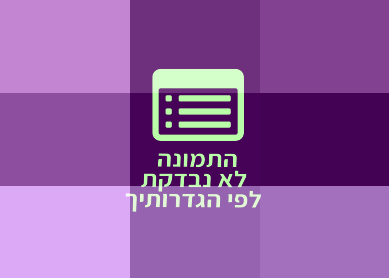

In [9]:
import matplotlib.pyplot as plt
plt.imshow(item['source_magnitudes'][..., 1][..., 0], aspect='auto', origin='lower')
plt.title('Magnitude spectrogram of vocals source')
plt.xlabel('Time frame')
plt.ylabel('Frequency bin')
plt.show()

We can do this inside a `transform` using `IndexSources`, which takes two
arguments:

- Which key to use for indexing
- Which index (or indices) to extract

In [10]:
index_sources = nussl_tfm.IndexSources('source_magnitudes', 1)
item = index_sources(item)

Let's take a look at the shapes again, and also plot it:

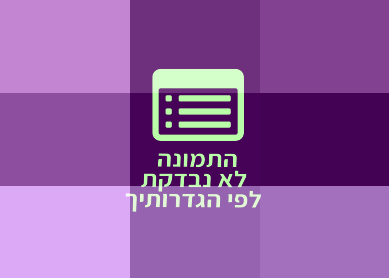

(257, 1724, 1, 1) (257, 1724, 1) (257, 1724, 1, 2)


In [11]:
import matplotlib.pyplot as plt
plt.imshow(item['source_magnitudes'][..., 0, 0], aspect='auto', origin='lower')
plt.title('Magnitude spectrogram of vocals source')
plt.xlabel('Time frame')
plt.ylabel('Frequency bin')
plt.show()

print(item['source_magnitudes'].shape, item['mix_magnitude'].shape, item['ideal_binary_mask'].shape)

Note that `item['source_magnitudes']` has only one source now, the vocals source. By changing
which index, we can change the sort of model we are training from a vocals model to an 
accompaniment model, or to a drums model, etc. if we don't use `SumSources`. Note that the
`ideal_binary_mask` shape is unaffected, as we didn't tell `IndexSources` to operate on that
key.

Next, we've got to prep our data dictionary so that it can be fed to our model. To do this, we need
them to be PyTorch tensors. We also need to exclude anything that is incompatible with PyTorch 
(such as the AudioSignal objects), and we'll need to make sure the time axis is on the first
non-batch dimension. To do this, we'll use the `ToSeparationModel` transform:

In [12]:
to_separation_model = nussl_tfm.ToSeparationModel()
item = to_separation_model(item)

Let's look at what's in the dictionary:

In [13]:
print(item.keys())

dict_keys(['mix_magnitude', 'ideal_binary_mask', 'source_magnitudes'])


So the `mix` and `sources` keys were discarded because they contained AudioSignal objects that can't be fed to 
a PyTorch model. The remaining keys look like this:

In [14]:
for key in item:
    print(key, type(item[key]), item[key].shape)

mix_magnitude <class 'torch.Tensor'> torch.Size([1724, 257, 1])
ideal_binary_mask <class 'torch.Tensor'> torch.Size([1724, 257, 1, 2])
source_magnitudes <class 'torch.Tensor'> torch.Size([1724, 257, 1, 1])


They're all tensors, and the time-axis is correclty placed in the first dimension, which is
what `nussl`'s implementation of the different neural building blocks expects. 

Finally, let's put all of these together into a single transform:

In [15]:
tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

item = train_data[0]
print("Before transforms")
for key in item:
    print(key, type(item[key]))
print("\nAfter transforms")
item = tfm(item)
for key in item:
    print(key, type(item[key]))

Before transforms
mix <class 'nussl.core.audio_signal.AudioSignal'>
sources <class 'dict'>
metadata <class 'dict'>

After transforms
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


We can initialize our mixer with these transforms so they always happen when we draw an
item from the dataset:

In [16]:
fg_path = "~/.nussl/tutorial/train"
train_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=1000, coherent_prob=1.0)

item = train_data[0]
print("Item from train data")
for key in item:
    print(key, type(item[key]))

fg_path = "~/.nussl/tutorial/valid"
val_data = data.on_the_fly(stft_params, transform=tfm, fg_path=fg_path, num_mixtures=500)

test_tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])

fg_path = "~/.nussl/tutorial/test"
test_data = data.on_the_fly(stft_params, transform=test_tfm, fg_path=fg_path, num_mixtures=100)

Item from train data
index <class 'int'>
mix_magnitude <class 'torch.Tensor'>
ideal_binary_mask <class 'torch.Tensor'>
source_magnitudes <class 'torch.Tensor'>


Note that when used inside a dataset, there is one additional item which is the
index of the dataset item. This is for `nussl.datasets.transforms.Cache`, which allows
users to *cache* items in case items are created in a computationally expensive way.

Note that we used a different transform for test, as we want to use items from test
to actually evaluate our model using proper metrics such as SI-SDR.

Next, let's put together our model and start feeding data into it.

## Building the model

We'll use the model we built up in the previous chapter - a recurrent mask-inference model:

In [17]:
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding
from torch import nn
import torch

class Model(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output

`nussl` has a special class - `nussl.ml.SeparationModel` which all models must integrate with. This is for 
ease of deployment. The model code above is not yet built how `nussl` expects.
Integrating a model with `nussl` is an easy three-step process:

1. *Register* your model code with nussl via `nussl.ml.register_module`.
2. *Build* a configuration function for your model that defines the inputs and outputs.
3. *Instantiate* your model via the output of the configuration function.

Let's convert the model above into a `SeparationModel` that is compatible with `nussl` by
adding a class method. We'll also give our model a more descriptive name than `Model`:

In [18]:
from nussl.ml.networks.modules import AmplitudeToDB, BatchNorm, RecurrentStack, Embedding
from torch import nn
import torch

class MaskInference(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
        mask = self.embedding(data)
        estimates = mix_magnitude.unsqueeze(-1) * mask
        
        output = {
            'mask': mask,
            'estimates': estimates
        }
        return output
    
    # Added function
    @classmethod
    def build(cls, num_features, num_audio_channels, hidden_size, 
              num_layers, bidirectional, dropout, num_sources, 
              activation='sigmoid'):
        # Step 1. Register our model with nussl
        nussl.ml.register_module(cls)
        
        # Step 2a: Define the building blocks.
        modules = {
            'model': {
                'class': 'MaskInference',
                'args': {
                    'num_features': num_features,
                    'num_audio_channels': num_audio_channels,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'bidirectional': bidirectional,
                    'dropout': dropout,
                    'num_sources': num_sources,
                    'activation': activation
                }
            }
        }
        
        
        # Step 2b: Define the connections between input and output.
        # Here, the mix_magnitude key is the only input to the model.
        connections = [
            ['model', ['mix_magnitude']]
        ]
        
        # Step 2c. The model outputs a dictionary, which SeparationModel will
        # change the keys to model:mask, model:estimates. The lines below 
        # alias model:mask to just mask, and model:estimates to estimates.
        # This will be important later when we actually deploy our model.
        for key in ['mask', 'estimates']:
            modules[key] = {'class': 'Alias'}
            connections.append([key, f'model:{key}'])
        
        # Step 2d. There are two outputs from our SeparationModel: estimates and mask.
        # Then put it all together.
        output = ['estimates', 'mask',]
        config = {
            'name': cls.__name__,
            'modules': modules,
            'connections': connections,
            'output': output
        }
        # Step 3. Instantiate the model as a SeparationModel.
        return nussl.ml.SeparationModel(config)

nf = stft_params.window_length // 2 + 1
nac = 1
model = MaskInference.build(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')

`SeparationModel` contain a lot more than just your model! They also include a lot
of metadata about your model, including snapshots of your code! Let's look at the
model config:

In [19]:
print(model.config)

{'name': 'MaskInference', 'modules': {'model': {'class': 'MaskInference', 'args': {'num_features': 257, 'num_audio_channels': 1, 'hidden_size': 50, 'num_layers': 2, 'bidirectional': True, 'dropout': 0.3, 'num_sources': 1, 'activation': 'sigmoid'}, 'module_snapshot': 'No module snapshot could be found. Did you define your class in an interactive Python environment? See https://bugs.python.org/issue12920 for more details.'}, 'mask': {'class': 'Alias', 'module_snapshot': 'class Alias(nn.Module):\n    """\n    Super simple module that just passes the data through without altering it, so\n    that the output of a model can be renamed in a SeparationModel.\n    """\n    def forward(self, data):\n        return data\n', 'args': {}}, 'estimates': {'class': 'Alias', 'module_snapshot': 'class Alias(nn.Module):\n    """\n    Super simple module that just passes the data through without altering it, so\n    that the output of a model can be renamed in a SeparationModel.\n    """\n    def forward(s

Printing the actual model appends some information about the number of parameters:

In [20]:
print(model)

SeparationModel(
  (layers): ModuleDict(
    (estimates): Alias()
    (mask): Alias()
    (model): MaskInference(
      (amplitude_to_db): AmplitudeToDB()
      (input_normalization): BatchNorm(
        (batch_norm): BatchNorm1d(257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (recurrent_stack): RecurrentStack(
        (rnn): LSTM(257, 50, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
      )
      (embedding): Embedding(
        (linear): Linear(in_features=100, out_features=257, bias=True)
      )
    )
  )
)
Number of parameters: 210871


The actual configuration of the model is always known as well inside the config:

In [21]:
model.config['modules']['model']['args']

{'num_features': 257,
 'num_audio_channels': 1,
 'hidden_size': 50,
 'num_layers': 2,
 'bidirectional': True,
 'dropout': 0.3,
 'num_sources': 1,
 'activation': 'sigmoid'}

Finally, let's look at one of these snapshots:

In [22]:
print(model.config['modules']['model']['module_snapshot'])

No module snapshot could be found. Did you define your class in an interactive Python environment? See https://bugs.python.org/issue12920 for more details.


Uh oh! Since we're working in a IPython notebook, the `inspect` module we're using in Python
doesn't work (see https://bugs.python.org/issue12920). Let's import the same exact model code
from our `common` library instead, and take a look:

In [23]:
from common.models import MaskInference

nf = stft_params.window_length // 2 + 1
nac = 1
model = MaskInference.build(nf, nac, 50, 2, True, 0.3, 1, 'sigmoid')

In [24]:
print(model.config['modules']['model']['module_snapshot'])

class MaskInference(nn.Module):
    def __init__(self, num_features, num_audio_channels, hidden_size,
                 num_layers, bidirectional, dropout, num_sources, 
                activation='sigmoid'):
        super().__init__()
        
        self.amplitude_to_db = AmplitudeToDB()
        self.input_normalization = BatchNorm(num_features)
        self.recurrent_stack = RecurrentStack(
            num_features * num_audio_channels, hidden_size, 
            num_layers, bool(bidirectional), dropout
        )
        hidden_size = hidden_size * (int(bidirectional) + 1)
        self.embedding = Embedding(num_features, hidden_size, 
                                   num_sources, activation, 
                                   num_audio_channels)
        
    def forward(self, data):
        mix_magnitude = data # save for masking
        
        data = self.amplitude_to_db(mix_magnitude)
        data = self.input_normalization(data)
        data = self.recurrent_stack(data)
     

Now, if we make changes to the model as we are iterating in experiments, the model code
is always saved with every checkpoint.

```{warning}
If you don't trust your checkpoints, NEVER run code directly from a string via eval unless
you know exactly what it is going to do. Module snapshots are meant just to keep track
of changes as you iterate in experiments. If you trust them, you can create the class from
the string, but it's strongly discouraged for security reasons.
```

Now that we've got a model, let's feed an item from our dataset into it. We'll need to do 
two things for this to work:

1. Add a batch dimension by unsqueezing along the 0th axis.
2. Cast the item to a `float`, the way PyTorch expects it.

In [25]:
item = train_data[0]
for key in item:
    if torch.is_tensor(item[key]):
        item[key] = item[key].float().unsqueeze(0)
output = model(item)

What's in the output? Let's take a look:

In [26]:
for key in output:
    print(key, type(output[key]), output[key].shape)

estimates <class 'torch.Tensor'> torch.Size([1, 1724, 257, 1, 1])
mask <class 'torch.Tensor'> torch.Size([1, 1724, 257, 1, 1])


We've got the estimates and we've got a mask! You can also put `SeparationModel`s 
into ` verbose` mode to see exactly what's happening in the forward pass: 

In [27]:
model.verbose = True
output = model(item)

['mix_magnitude'] -> model 
	Took inputs: (1, 1724, 257, 1) 
	Produced 'model:mask': (1, 1724, 257, 1, 1), 'model:estimates': (1, 1724, 257, 1, 1) 
	Statistics:
		model:mask
			min: 0.2604
			max: 0.7350
			mean: 0.5005
			std: 0.0618
		model:estimates
			min: 0.0000
			max: 0.1415
			mean: 0.0016
			std: 0.0042
['model:mask'] -> mask 
	Took inputs: (1, 1724, 257, 1, 1) 
	Produced 'mask': (1, 1724, 257, 1, 1) 
	Statistics:
		mask
			min: 0.2604
			max: 0.7350
			mean: 0.5005
			std: 0.0618
['model:estimates'] -> estimates 
	Took inputs: (1, 1724, 257, 1, 1) 
	Produced 'estimates': (1, 1724, 257, 1, 1) 
	Statistics:
		estimates
			min: 0.0000
			max: 0.1415
			mean: 0.0016
			std: 0.0042


This is really useful to see whether or not activations are getting saturated,
what the range of the data is at each layer, etc. Putting models into verbose
mode is a handy way of checking shapes and value ranges, making it useful
for debugging.

Alright, let's train this model! Let's overfit it to this single item to make
sure everything is working.

## Training

The core of training a model is to set up the training loop. To do this, we need
to set up a few things:

- Loss function: this is what we're optimizing for. We want to change our model 
  parameters such that the loss function goes *down*.
- Optimizer: this is what actually takes a step on the model parameters.

If you've done deep learning with PyTorch before, the steps below will make
sense. The way we're going to formulate this is to define a function that, given
a single batch of data, how to take a *training* step on for the model:

In [28]:
import torch

nf = stft_params.window_length // 2 + 1
nac = 1
model = MaskInference.build(nf, nac, 50, 1, True, 0.0, 1, 'sigmoid')
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

def train_step(batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    return loss.item() # return the loss for bookkeeping.

SeparationModel(
  (layers): ModuleDict(
    (estimates): Alias()
    (mask): Alias()
    (model): MaskInference(
      (amplitude_to_db): AmplitudeToDB()
      (input_normalization): BatchNorm(
        (batch_norm): BatchNorm1d(257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (recurrent_stack): RecurrentStack(
        (rnn): LSTM(257, 50, batch_first=True, bidirectional=True)
      )
      (embedding): Embedding(
        (linear): Linear(in_features=100, out_features=257, bias=True)
      )
    )
  )
)
Number of parameters: 150071


Now let's make a batch and pass it through the model, and call 
`train_step` over and over to train the model.

In [29]:
%%capture
# Comment out the line above to see the output
# of this cell in Colab or Jupyter Notebook
import tqdm

item = train_data[0] # Because of the transforms, this produces tensors.
batch = {} # A batch of size 1, in this case. Usually we'd have more.
for key in item:
    if torch.is_tensor(item[key]):
        batch[key] = item[key].float().unsqueeze(0)
    
N_ITERATIONS = 100
loss_history = [] # For bookkeeping

pbar = tqdm.tqdm(range(N_ITERATIONS))
for _ in pbar:
    loss_val = train_step(batch)
    loss_history.append(loss_val)
    pbar.set_description(f'Loss: {loss_val:.6f}')

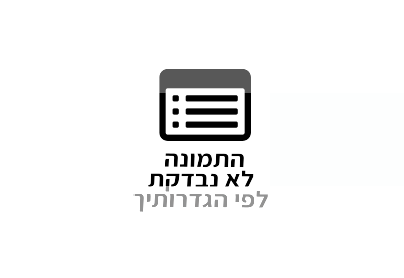

In [30]:
plt.plot(loss_history)
plt.xlabel('# of iterations')
plt.ylabel('Training loss')
plt.title('Train loss history of our model')
plt.show()

*nussl* comes loaded with a bunch of training utilities, which are powered by
[PyTorch Ignite](https://github.com/pytorch/ignite). These utilities abstract away
some of the steps above. The key concept of PyTorch Ignite is the "engine". An engine
essentially calls our training function on batches from the dataset, for a set number
of epochs. Engines also fire off a bunch of events during training that can be captured
and handled by callback functions. For more detailed information, check out the
[PyTorch Ignite documentation](https://pytorch.org/ignite/engine.html#ignite-engine). To
make things compatible with Ignite, we have to change the `train_step` function a bit to
take an *engine* as the first argument. We'll also change it so that it returns a dictionary:

In [31]:
def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item()
    }
    
    return loss_vals # return the loss for bookkeeping.

We'll also need a validation step, which doesn't actually update the model:

In [32]:
def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {'L1Loss': loss.item()}
    return loss_vals # return the loss for bookkeeping.

Now, let's build up our entire training script, using *nussl*. We'll copy paste
things from above so that it's all in one spot:

In [33]:
import nussl
import torch
from nussl.datasets import transforms as nussl_tfm
from common.models import MaskInference
from common import utils, data
from pathlib import Path

utils.logger()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MAX_MIXTURES = int(1e8) # We'll set this to some impossibly high number for on the fly mixing.

stft_params = nussl.STFTParams(window_length=512, hop_length=128)

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
    nussl_tfm.MagnitudeSpectrumApproximation(),
    nussl_tfm.IndexSources('source_magnitudes', 1),
    nussl_tfm.ToSeparationModel(),
])

train_folder = "~/.nussl/tutorial/train"
val_folder = "~/.nussl/tutorial/valid"

train_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=train_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
train_dataloader = torch.utils.data.DataLoader(
    train_data, num_workers=1, batch_size=10)

val_data = data.on_the_fly(stft_params, transform=tfm, 
    fg_path=val_folder, num_mixtures=10, coherent_prob=1.0)
val_dataloader = torch.utils.data.DataLoader(
    val_data, num_workers=1, batch_size=10)

nf = stft_params.window_length // 2 + 1
model = MaskInference.build(nf, 1, 50, 1, True, 0.0, 1, 'sigmoid')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nussl.ml.train.loss.L1Loss()

def train_step(engine, batch):
    optimizer.zero_grad()
    output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )
    
    loss.backward() # backwards + gradient step
    optimizer.step()
    
    loss_vals = {
        'L1Loss': loss.item(),
        'loss': loss.item()
    }
    
    return loss_vals

def val_step(engine, batch):
    with torch.no_grad():
        output = model(batch) # forward pass
    loss = loss_fn(
        output['estimates'],
        batch['source_magnitudes']
    )    
    loss_vals = {
        'L1Loss': loss.item(), 
        'loss': loss.item()
    }
    return loss_vals

# Create the engines
trainer, validator = nussl.ml.train.create_train_and_validation_engines(
    train_step, val_step, device=DEVICE
)

# We'll save the output relative to this notebook.
output_folder = Path('.').absolute()

# Adding handlers from nussl that print out details about model training
# run the validation step, and save the models.
nussl.ml.train.add_stdout_handler(trainer, validator)
nussl.ml.train.add_validate_and_checkpoint(output_folder, model, 
    optimizer, train_data, trainer, val_dataloader, validator)

trainer.run(
    train_dataloader, 
    epoch_length=10, 
    max_epochs=1
)

State:
	iteration: 10
	epoch: 1
	epoch_length: 10
	max_epochs: 1
	output: <class 'dict'>
	batch: <class 'dict'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>
	epoch_history: <class 'dict'>
	iter_history: <class 'dict'>
	past_iter_history: <class 'dict'>
	saved_model_path: /Users/prem/research/tutorial/book/training/checkpoints/best.model.pth
	output_folder: <class 'pathlib.PosixPath'>

Scripts like this are the starting point for your separation experiments. The script above builds up a
Scaper object which creates mixtures on the fly for training and validating the model. It then feeds 
mixtures to a deep learning model. Finally, the script saves the checkpoints for the model and for 
the optimizer for loading it back up.

## Deployment

Finally, we'll look at how the model can be loaded into a *nussl* separation object so you can
play around with it! The way to do this is to use *nussl*'s DeepMaskEstimation class:

In [34]:
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path='checkpoints/best.model.pth',
    device=DEVICE,
)

/Users/prem/miniconda3/envs/ismir-2020/lib/python3.8/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/Users/prem/miniconda3/envs/ismir-2020/lib/python3.8/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


Let's test it on a music mixture to see what it learned!

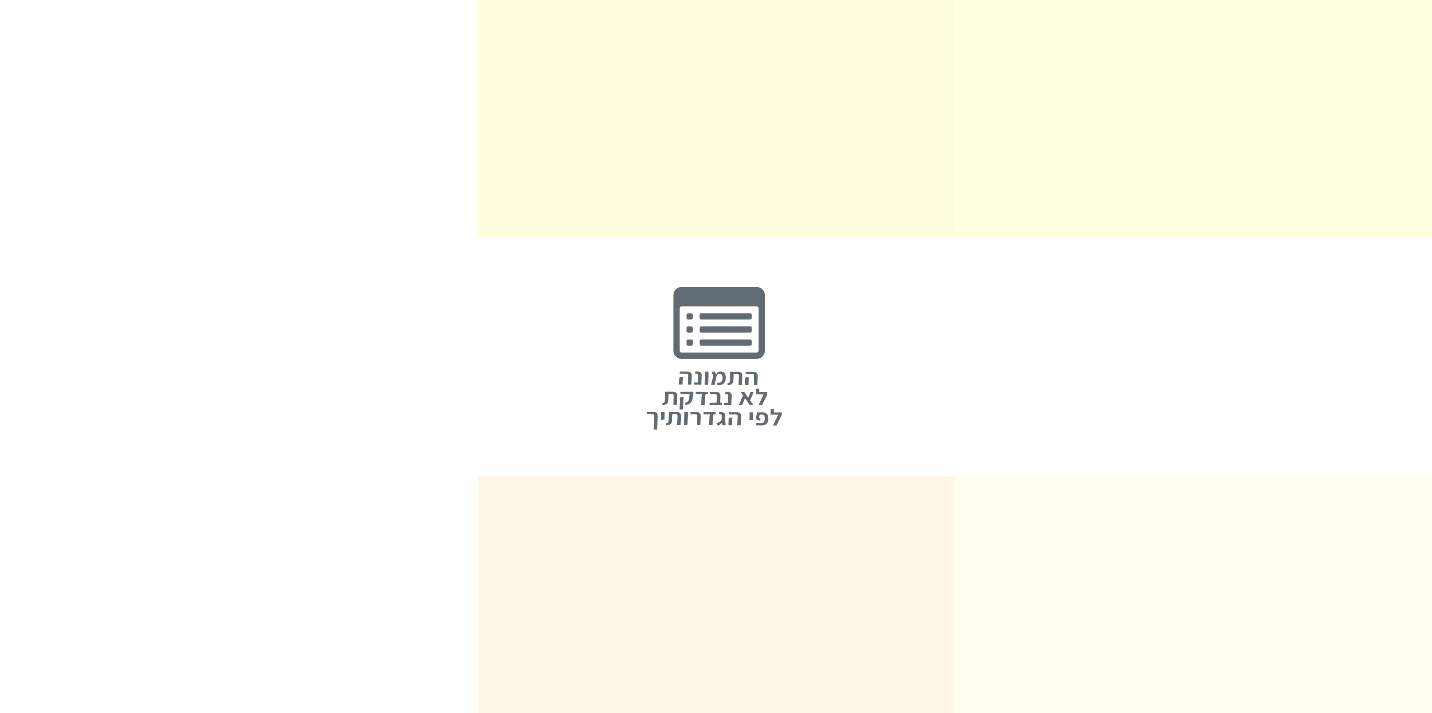


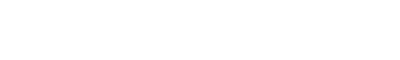
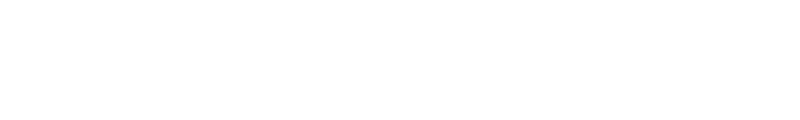
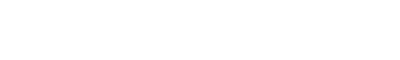

In [35]:
from common import viz

test_folder = "~/.nussl/tutorial/test/"
test_data = data.mixer(stft_params, transform=None, 
    fg_path=test_folder, num_mixtures=MAX_MIXTURES, coherent_prob=1.0)
item = test_data[0]

separator.audio_signal = item['mix']
estimates = separator()
# Since our model only returns one source, let's tack on the
# residual (which should be accompaniment)
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)

Clearly, the model needs more training. But it's a start! So far it has learned 
the frequency bands where things can be separated.

```{note}
Go back to the training script above and change the hyperparameters! Most importantly,
change the number of epochs that it runs for, as well as the epoch length. You'll start
to see more reasonable results after around 25 epochs, usually.
```

Finally, as we've done for other algorithms already, let's interact with our model!

## Evaluation

Next, let's evaluate our model on a test set. We'll evaluate the model on the 
MUSDB test set (using 7-second clips). For the sake of quick execution, we'll
evaluate the model on just a few clips from it:

In [38]:
import json

tfm = nussl_tfm.Compose([
    nussl_tfm.SumSources([['bass', 'drums', 'other']]),
])
test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)

# Just do 5 items for speed. Change to 50 for actual experiment.
for i in range(5):
    item = test_dataset[i]
    separator.audio_signal = item['mix']
    estimates = separator()

    source_keys = list(item['sources'].keys())
    estimates = {
        'vocals': estimates[0],
        'bass+drums+other': item['mix'] - estimates[0]
    }

    sources = [item['sources'][k] for k in source_keys]
    estimates = [estimates[k] for k in source_keys]

    evaluator = nussl.evaluation.BSSEvalScale(
        sources, estimates, source_labels=source_keys
    )
    scores = evaluator.evaluate()
    output_folder = Path(output_folder).absolute()
    output_folder.mkdir(exist_ok=True)
    output_file = output_folder / sources[0].file_name.replace('wav', 'json')
    with open(output_file, 'w') as f:
        json.dump(scores, f, indent=4)

The script above iterates over items in the test dataset and calculates a lot of
metrics for each one. These metrics are saved to JSON files whose name is the
same as the name of the item's filename. We can aggregate all of the metrics
into a single report card using *nussl*:

In [42]:
import glob
import numpy as np

json_files = glob.glob(f"*.json")
df = nussl.evaluation.aggregate_score_files(
    json_files, aggregator=np.nanmedian)
nussl.evaluation.associate_metrics(separator.model, df, test_dataset)
report_card = nussl.evaluation.report_card(
    df, report_each_source=True)
print(report_card)

                                                                      
                        MEAN +/- STD OF METRICS                         
                                                                      
┌────────────┬──────────────────┬──────────────────┬──────────────────┐
│ METRIC     │     OVERALL      │ BASS+DRUMS+OTHER │      VOCALS      │
╞════════════╪══════════════════╪══════════════════╪══════════════════╡
│ #          │        10        │        5         │        5         │
├────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SDR     │  -0.01 +/-  5.23 │   4.21 +/-  3.20 │  -4.24 +/-  2.58 │
├────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SIR     │   0.12 +/-  5.31 │   4.41 +/-  3.27 │  -4.16 +/-  2.61 │
├────────────┼──────────────────┼──────────────────┼──────────────────┤
│ SI-SAR     │  15.54 +/-  2.89 │  17.88 +/-  1.92 │  13.19 +/-  1.18 │
├────────────┼──────────────────┼──────────────────┼─────────────

Finally, we can save our model after evaluation, because we associated this report card
with the checkpoint!

In [44]:
separator.model.save('checkpoints/best.model.pth')

'checkpoints/best.model.pth'

Let's open back up our model into a new separator and see what's inside the saved 
model!

In [54]:
model_checkpoint = torch.load('checkpoints/best.model.pth')

We can take a look at what's in the metadata:

In [55]:
model_checkpoint['metadata'].keys()

dict_keys(['config', 'nussl_version', 'evaluation', 'test_dataset'])

There's a bunch of cool stuff in here:

- Training/validation loss curves
- The version of nussl that was used to make this model
- Details of the test, train, and validation datasets
- The report card seen above containing all the model metrics

Finally, let's launch our model so we can interact with it!

## Interaction

In [37]:
%%capture
separator.interact(share=True, source='microphone')

Share the link with your colleagues or collaborators so they can investigate your model
as well!